In [1]:
import os
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16_bn

In [2]:
if not os.path.exists('data'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !mv dataset1 data

In [3]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [4]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'data/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'data/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'data/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [5]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=val_ds.collate_fn)

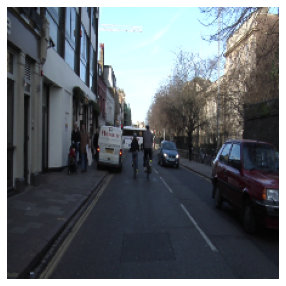

In [6]:
show(trn_ds[10][0])

In [7]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [8]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [9]:
model = vgg16_bn(pretrained=True).features
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16): ReLU(inplace=True)
  (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (19): ReLU(inplace=True)
  (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (22): ReLU(inplace=True)
  (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (24): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (25): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (26): ReLU(inplace=True)
  (27): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (29): ReLU(inplace=True)
  (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (32): ReLU(inplace=True)
  (33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (35): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (36): ReLU(inplace=True)
  (37): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (38): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (39): ReLU(inplace=True)
  (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (42): ReLU(inplace=True)
  (43): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [15]:
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        # print("Bottleneck :: ", x.shape)

        x = self.up_conv6(x)
        # print("Upconv",x.shape)
        # print("Block" , block5.shape)
        
        x = torch.cat([x, block5], dim=1)
        # print("cat ", x.shape)
        x = self.conv6(x)
        # print("Conv ", x.shape)

        x = self.up_conv7(x)
        # print("Upconv",x.shape)
        # print("Block" , block4.shape)
        x = torch.cat([x, block4], dim=1)
        # print("cat ", x.shape)
        x = self.conv7(x)
        # print("Conv ", x.shape)

        x = self.up_conv8(x)
        # print("Upconv",x.shape)
        # print("Block" , block3.shape)
        x = torch.cat([x, block3], dim=1)
        # print("cat ", x.shape)
        x = self.conv8(x)
        # print("Conv ", x.shape)

        x = self.up_conv9(x)
        # print("Upconv",x.shape)
        # print("Block" , block2.shape)
        x = torch.cat([x, block2], dim=1)
        # print("cat ", x.shape)
        x = self.conv9(x)
        # print("Conv ", x.shape)

        x = self.up_conv10(x)
        # print("Upconv",x.shape)
        # print("Block" , block1.shape)
        x = torch.cat([x, block1], dim=1)
        # print("cat ", x.shape)
        x = self.conv10(x)
        # print("Conv ", x.shape)

        x = self.conv11(x)
        # print("Conv ", x.shape)

        return x

In [16]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [17]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [18]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [20]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000  val_loss: 1.305  trn_loss: 1.659  val_acc: 0.773  trn_acc: 0.722  (18.54s - 352.23s remaining)
EPOCH: 2.000  val_loss: 1.095  trn_loss: 1.211  val_acc: 0.812  trn_acc: 0.805  (34.02s - 306.18s remaining)
EPOCH: 3.000  val_loss: 0.900  trn_loss: 0.926  val_acc: 0.819  trn_acc: 0.834  (50.56s - 286.52s remaining)
EPOCH: 4.000  val_loss: 0.815  trn_loss: 0.726  val_acc: 0.832  trn_acc: 0.856  (64.34s - 257.36s remaining)
EPOCH: 5.000  val_loss: 0.629  trn_loss: 0.614  val_acc: 0.865  trn_acc: 0.871  (80.40s - 241.20s remaining)
EPOCH: 6.000  val_loss: 0.794  trn_loss: 0.542  val_acc: 0.805  trn_acc: 0.881  (98.48s - 229.79s remaining)
EPOCH: 7.000  val_loss: 0.550  trn_loss: 0.482  val_acc: 0.857  trn_acc: 0.888  (113.89s - 211.51s remaining)
EPOCH: 8.000  val_loss: 0.512  trn_loss: 0.450  val_acc: 0.867  trn_acc: 0.891  (129.04s - 193.55s remaining)
EPOCH: 9.000  val_loss: 0.481  trn_loss: 0.407  val_acc: 0.870  trn_acc: 0.898  (143.86s - 175.83s remaining)
EPOCH: 10.000  v

100%|██████████| 121/121 [00:00<00:00, 5270.98it/s]


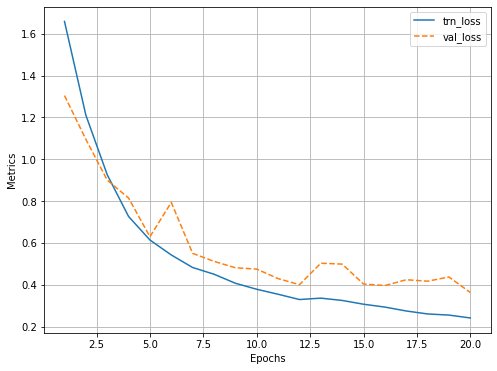

In [21]:
log.plot_epochs(['trn_loss','val_loss'])

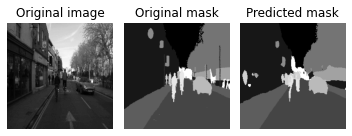

In [22]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])